In [ ]:
### LangGraph 多智能体协作中文指南

在单个领域中，通常一个智能体能够有效地使用一些工具，但即使是使用强大的模型（例如 GPT-4），它在使用大量工具时效果可能会有所降低。

一种解决复杂任务的方法是采用“分而治之”的方式：为每个任务或领域创建一个专门的智能体，并将任务路由到正确的“专家”。

本指南灵感来自 Wu 等人的论文《AutoGen: 通过多智能体对话实现下一代 LLM 应用》 展示了使用 LangGraph 进行多智能体协作的一种方法。

最终的图表看起来可能像下图所示：

![simple_multi_agent_diagram](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/img/simple_multi_agent_diagram.png)

#### 说明

**经过多次测试，多智能体仅在 `gpt-4o` 上成功运行**。见指南最后的 **GPT-4o 模型生成结果** 章节。

当切换为 `gpt-4o-mini` 时，模型表现为无法成功调用 `Python REPL 工具执行代码`，但可以生成对应的 Python 代码。


In [1]:
%%capture --no-stderr
%pip install langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [30]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

# 可选：在 LangSmith 中添加追踪功能
tavily_api_key = os.getenv('TAVILY_API_KEY')
langsmith_api_key = os.getenv('LANGSMITH_API_KEY')
openai_api_key = os.getenv("OPENAI_API_KEY")
base_url="https://api.javis3000.com/v1"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
LANGCHAIN_PROJECT="20240911homework"  #建立langsmith上的项目
os.environ["LANGCHAIN_PROJECT"] = "20240911homework"#读入环境变量


In [31]:
#运行一次有数据上传了项目就自动在langsmith中建立了
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini",base_url=base_url)
llm.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_80a1bad4c7', 'finish_reason': 'stop', 'logprobs': None}, id='run-2658617b-8372-41c7-b331-d03becb4c8bb-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20})


### 创建智能体

以下助手函数将帮助我们创建智能体。这些智能体将成为图中的节点。

#### 注释说明：
- 该函数 `create_agent` 用于创建一个智能体，通过为该智能体提供系统消息和可以使用的工具来指定其行为。
- `ChatPromptTemplate.from_messages` 是用于构建该智能体的对话提示模板，系统消息告诉智能体它是如何与其他智能体协作的。
- 提示模板通过 `partial` 函数插入了系统消息和工具名称，使得智能体能够根据提供的工具执行任务。
- 最终，智能体被绑定到所提供的 LLM（大型语言模型）和工具列表中，构成一个完整的智能体逻辑。

In [32]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# 创建智能体的函数，绑定 LLM（大型语言模型） 和工具
def create_agent(llm, tools, system_message: str):
    """创建一个智能体。"""
    # 定义智能体的提示模板，包含系统消息和工具信息
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",  # 系统消息部分，描述智能体的行为逻辑
                "你是一个有帮助的 AI 助手，正在与其他助手协作。"
                " 使用提供的工具逐步解决问题。"
                " 如果你无法完全回答，没关系，另一个助手会接手，使用不同的工具继续。"
                " 尽你所能执行操作以取得进展。"
                " 如果你或其他助手有最终答案或可交付物，请在回复中加上 FINAL ANSWER 作为前缀，"
                " 让团队知道可以停止操作。"
                " 你可以使用以下工具：{tool_names}。\n{system_message}",  # 提供的工具名称和系统消息
            ),
            MessagesPlaceholder(variable_name="messages"),  # 用于替换的消息占位符
        ]
    )
    
    # 将系统消息部分和工具名称插入到提示模板中
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    
    # 将提示模板与语言模型和工具绑定
    return prompt | llm.bind_tools(tools)



### 定义工具

接下来我们定义一些未来智能体将使用的工具。

#### 注释说明：
- `tavily_tool`: 定义了一个 Tavily 搜索工具，可以搜索最多 5 条结果。
- `repl`: 定义了一个 Python REPL 工具，用于执行 Python 代码块。
- `python_repl` 函数：这是一个装饰的工具函数，接受 Python 代码作为输入，并通过 `PythonREPL` 环境执行代码。成功执行后返回执行的代码和输出。如果发生错误，则捕获并返回错误信息。


In [33]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# 定义 Tavily 搜索工具和 Python 代码执行工具
# Tavily 搜索工具，用于搜索最多 5 条结果
tavily_tool = TavilySearchResults(max_results=5)
repl = PythonREPL()

# Python REPL 工具，用于执行 Python 代码
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        # 如果代码执行失败，返回错误信息
        return f"Failed to execute. Error: {repr(e)}"
    
    # 成功执行的返回信息，包含执行的代码和标准输出
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    
    # 返回结果，并提示如果任务已完成，请回复 FINAL ANSWER
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


### 创建图

定义工具和辅助函数后，接下来我们将创建各个智能体，并使用 LangGraph 使它们互相通信。

#### 定义状态

我们首先定义图的状态。这将是一个消息列表，并包含一个键来跟踪最近的发送者。

#### 注释说明：
- `AgentState` 是一个 `TypedDict`，它定义了图中传递的状态对象，包括 `messages` 和 `sender`。`messages` 用于存储传递的消息，`sender` 用于跟踪消息的发送者。


In [34]:
import operator
from typing import Annotated, Sequence, TypedDict


# 定义图中传递的对象，包含消息和发送者信息
class AgentState(TypedDict):
    # messages 是传递的消息，使用 Annotated 和 Sequence 来标记类型
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # sender 是发送消息的智能体
    sender: str


#### 定义智能体节点

下面我们定义智能体节点函数（`agent_node`)，然后使用它定义2个智能体节点：
- Researcher
- Chart Generator

#### 注释说明：

- `agent_node` 函数是一个辅助函数，用于创建一个智能体节点。它接受当前的 `state`（状态）、`agent`（智能体） 和 `name`（智能体的名称），并返回一个新的状态字典，包含消息和发送者。
- `research_agent`: 使用 `create_agent` 函数创建了一个研究智能体，使用 `research_llm` 作为语言模型，并且绑定了 `tavily_tool` 搜索工具。
- `chart_agent`: 同样使用 `create_agent` 创建了图表生成器智能体，使用 `chart_llm` 作为语言模型，并绑定了 `python_repl` 代码执行工具。
- `functools.partial`: 用于创建特定名称的智能体节点，例如 `"Researcher"` 和 `"chart_generator"`，并与各自的智能体绑定。

In [35]:
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

# 辅助函数：为智能体创建一个节点
def agent_node(state, agent, name):
    # 调用智能体，获取结果
    result = agent.invoke(state)
    
    # 将智能体的输出转换为适合追加到全局状态的格式
    if isinstance(result, ToolMessage):
        pass  # 如果是工具消息，跳过处理
    else:
        # 将结果转换为 AIMessage，并排除部分字段
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    
    # 返回更新后的状态，包括消息和发送者
    return {
        "messages": [result],  # 包含新生成的消息
        # 我们使用严格的工作流程，通过记录发送者来知道接下来传递给谁
        "sender": name,
    }

In [36]:
# 使用 OpenAI 模型
research_llm =ChatOpenAI(model="gpt-4o",base_url=base_url)
chart_llm = ChatOpenAI(model="gpt-4o",base_url=base_url)


In [52]:
# 研究智能体及其节点
research_agent = create_agent(
    research_llm,  # 使用 research_llm 作为研究智能体的语言模型
    [tavily_tool],  # 研究智能体使用 Tavily 搜索工具
    system_message="在进行任何搜索之前，先花时间深入思考查询问题，必要时将其分解为更小的部分。"
        "然后，执行一次全面的搜索，确保所有查询的各个方面都得到处理。"
        "确保结果简洁、相关且具有可操作性，提供高价值见解，避免不必要的信息。"
        "注意不要回复FINAL ANSWER",  # 系统消息，指导智能体如何使用搜索工具
)
# 使用 functools.partial 创建研究智能体的节点，指定该节点的名称为 "Researcher"
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [46]:
# table生成器智能体及其节点
chart_agent = create_agent(
    chart_llm,  # 使用 chart_llm 作为图表生成器智能体的语言模型
    [python_repl],  # 图表生成器智能体使用 Python REPL 工具
    system_message="Given the data provided, generate and execute Python code to create clear and user-friendly charts. "
        "Ensure the chart is rendered directly and avoid returning raw code unless there's an error. "
        "If there is an issue, describe it clearly and provide the code as a fallback.",  # 系统消息，指导智能体如何生成图表
)
# 使用 functools.partial 创建图表生成器智能体的节点，指定该节点的名称为 "chart_generator"
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")


#### 定义工具节点

我们现在定义运行工具的节点 `ToolNode` ，将 Tavily 搜索工具和 Python REPL 工具作为一个工具节点，这样可以方便地在工作流中使用这些工具。

In [39]:
# 导入预构建的工具节点
from langgraph.prebuilt import ToolNode

# 定义工具列表，包括 Tavily 搜索工具和 Python REPL 工具
tools = [tavily_tool, python_repl]

# 创建工具节点，负责工具的调用
tool_node = ToolNode(tools)


#### 定义边逻辑

接下来定义边逻辑，以根据智能体的结果来决定下一步操作。

#### 注释说明：
- `router` 函数是工作流中的一个关键逻辑，用于根据当前的状态和消息内容来决定下一步的操作。
- 如果最新的消息中包含工具调用（`tool_calls`），则返回 `"call_tool"`，表示需要调用工具。
- 如果消息内容中包含 `"FINAL ANSWER"`，表示任务已经完成，返回 `"__end__"` 来结束任务。
- 如果没有满足以上条件，则返回 `"continue"`，表示继续任务并执行下一步操作。

In [40]:
#from typing import Literal

# 路由器函数，用于决定下一步是执行工具还是结束任务
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]  # 获取当前状态中的消息列表
    last_message = messages[-1]  # 获取最新的一条消息
    
    # 如果最新消息包含工具调用，则返回 "call_tool"，指示执行工具
    if last_message.tool_calls:
        return "call_tool"
    
    # 如果最新消息中包含 "FINAL ANSWER"，表示任务已完成，返回 "__end__" 结束工作流
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    
    # 如果既没有工具调用也没有完成任务，继续流程，返回 "continue"
    return "continue"


In [48]:
from typing import Literal
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state.get("messages", [])
    
    if not messages:
        return "continue"

    last_message = messages[-1]

    # 如果消息内容是生成的代码片段，调用工具执行代码
    if "def" in getattr(last_message, "content", "") or "import" in getattr(last_message, "content", ""):
        # 检测是否包含代码段关键字，如 def 或 import 来判断返回的是否是代码
        return "call_tool"
    
    # 检查是否有工具调用
    if getattr(last_message, "tool_calls", None):
        return "call_tool"
    
    # 检查是否包含 "FINAL ANSWER"
    if "FINAL ANSWER" in getattr(last_message, "content", ""):
        return "__end__"

    return "continue"




#### 定义图

我们现在将所有内容组合在一起，定义多智能体的完整状态图。

#### 注释说明：

- `StateGraph(AgentState)`：用于创建一个状态图 `workflow`，其状态由 `AgentState` 管理。
- `add_node`：将智能体节点 `Researcher`、`chart_generator` 和 `call_tool` 添加到状态图中，每个节点对应一个任务或功能。
- `add_conditional_edges`：为节点添加条件边，基于 `router` 函数的返回值来决定下一个要执行的步骤。
  - `continue`：继续到另一个智能体节点。
  - `call_tool`：调用工具节点。
  - `__end__`：结束流程。
- `add_edge`：将开始节点 `START` 与初始节点 `Researcher` 连接，定义工作流的启动顺序。
- `compile`：编译状态图，准备好执行任务。

In [41]:
# 创建一个状态图 workflow，使用 AgentState 来管理状态
workflow = StateGraph(AgentState)

# 将研究智能体节点、图表生成器智能体节点和工具节点添加到状态图中
workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

In [42]:
# 为 "Researcher" 智能体节点添加条件边，根据 router 函数的返回值进行分支
workflow.add_conditional_edges(
    "Researcher",
    router,  # 路由器函数决定下一步
    {
        "continue": "chart_generator",  # 如果 router 返回 "continue"，则传递到 chart_generator
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "chart_generator" 智能体节点添加条件边
workflow.add_conditional_edges(
    "chart_generator",
    router,  # 同样使用 router 函数决定下一步
    {
        "continue": "Researcher",  # 如果 router 返回 "continue"，则回到 Researcher
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "call_tool" 工具节点添加条件边，基于“sender”字段决定下一个节点
# 工具调用节点不更新 sender 字段，这意味着边将返回给调用工具的智能体
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],  # 根据 sender 字段判断调用工具的是哪个智能体
    {
        "Researcher": "Researcher",  # 如果 sender 是 Researcher，则返回给 Researcher
        "chart_generator": "chart_generator",  # 如果 sender 是 chart_generator，则返回给 chart_generator
    },
)


In [43]:
# 添加开始节点，将流程从 START 节点连接到 Researcher 节点
workflow.add_edge(START, "Researcher")

# 编译状态图以便后续使用
graph = workflow.compile()

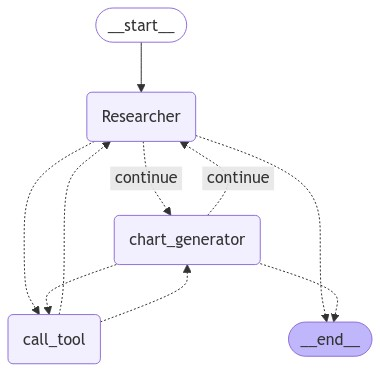

In [44]:
# 可视化图
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(f"Error generating graph: {e}")


### 执行图

接下来我们将使用多智能体，生成一些统计图表。

================================ Human Message =================================

获取最近二十年中国人民死于肥胖症的数据 and then plot a line chart with Python. End the task after generating the chart。
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_izsBn0epBM5mzHynfrv5f22x)
 Call ID: call_izsBn0epBM5mzHynfrv5f22x
  Args:
    query: 最近二十年中国死于肥胖症的数据
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.chinacdc.cn/gwxx/202309/t20230921_269712.html", "content": "\u624b\u673a\u7248\n\u5fae\u4fe1\u516c\u4f17\u53f7\n2023\u4e2d\u56fd\u80a5\u80d6\u5730\u56fe\u53d1\u5e03\uff01\u8d8540%\u7537\u6027\u8d85\u91cd\uff0c\u5317\u65b9\u8d85\u91cd/\u80a5\u80d6\u7387\u9ad8\u8fc7\u5357\u65b9\uff0c\u53d1\u8fbe\u5730\u533a\u8d85\u91cd/\u80a5\u80d6\u7387\u4f4e\n\u80a5\u80d6\u662f\u4e00\u79cd\u6162\u6027\u3001\u590d\u53d1\u6027\u548c\u8fdb\u884c\u602

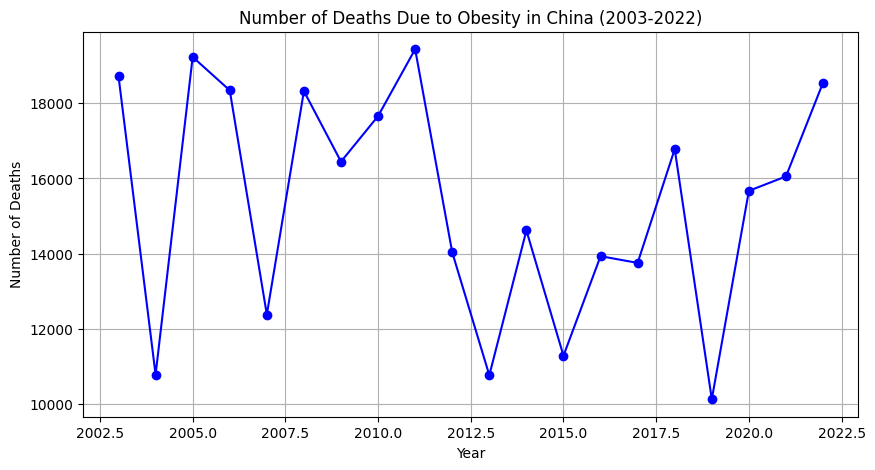

================================== Ai Message ==================================
Name: chart_generator
Tool Calls:
  python_repl (call_H5g1zhXG6p1XwiMr8WEjsv7b)
 Call ID: call_H5g1zhXG6p1XwiMr8WEjsv7b
  Args:
    code: import matplotlib.pyplot as plt
import numpy as np

# 假设的过去二十年中国死于肥胖症的人数数据（每年随机生成）
years = np.arange(2003, 2023)
deaths = np.random.randint(10000, 20000, size=20)  # 随机生成每年的死亡人数

# 创建折线图
plt.figure(figsize=(10, 5))
plt.plot(years, deaths, marker='o', linestyle='-', color='b')

# 设置图表标题和标签
plt.title('Number of Deaths Due to Obesity in China (2003-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.grid(True)

# 显示图表
plt.show()
================================= Tool Message =================================
Name: python_repl

Successfully executed:
```python
import matplotlib.pyplot as plt
import numpy as np

# 假设的过去二十年中国死于肥胖症的人数数据（每年随机生成）
years = np.arange(2003, 2023)
deaths = np.random.randint(10000, 20000, size=20)  # 随机生成每年的死亡人数

# 创建折线图
plt.figure(figsize=(1

In [55]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="获取最近二十年中国人民死于肥胖症的数据 "
            "and then plot a line chart with Python. End the task after generating the chart。"
            )
        ],
    },
    # 设置最大递归限制
    {"recursion_limit": 20},
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()  # 打印消息内容
